In [45]:
# Import all required libraries.
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit

In [46]:
# Filter out the warnings.
import warnings
warnings.filterwarnings("ignore")

In [47]:
# Check if CUDA is available.
# If so, assign the device to CUDA.
if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Found CUDA-enabled device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available on this machine.")

CUDA is available on this machine.
Found CUDA-enabled device: NVIDIA GeForce RTX 2060


In [48]:
class TorchVisionDataset(Dataset):
    '''
    Dataset class for handling the input image data.
    '''
    def __init__(self, data_dic, transform=None):
        # Initialize the file paths and labels from the input data dictionary.
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

        # Count for corrupted images.
        self.corrupted_count = 0

    def __len__(self):
        '''
        Returns the total number of samples in the dataset.
        '''
        return len(self.file_paths)

    
    def __getitem__(self, idx):
        '''
        Retrieves an image and its corresponding label from the dataset
        based on a provided index location, idx.
        '''
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        try:
            # Open the image file.
            image = Image.open(file_path)

            # Convert RGBA images to RGB.
            if image.mode == 'RGBA':
                image = image.convert('RGB')
            
            # Apply transformations (if specified).
            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            # Error handling for corrupted images.
            self.corrupted_count += 1
            print(self.corrupted_count)
            return torch.zeros(3, 224, 224), label

In [49]:
# Load image paths and store in an numpyp array, images.
images = glob.glob("data/*/*/*")
images = np.array(images)

# Load the corresponding labels by splitting the file path on \ delimiter.
# Take the second from last entry in the array as the label (black, blue, gree, other).
labels = np.array([f.split("\\")[-2] for f in images])

# Print the length of the images and labels array.
# Print the first entry of the images and labels array.
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

165
165
test-data\Black\ball_of_lint.jpeg
Black


In [50]:
# Get all unique classes from the label array.
classes = np.unique(labels).flatten()
print(classes)

# Convert labels to integers.
labels_int = np.zeros(labels.size, dtype=np.int64)
print(labels_int.shape)

# Assign integer labels to each class.
for ii, jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['Black' 'Blue' 'Green' 'Other']
(165,)


In [51]:
# Iterate through each label (0 to 3) and print the total sum
# of samples for each.
for ii in range(4):
    print("Label ", ii, ":", (labels_int == ii).sum())

Label  0 : 48
Label  1 : 55
Label  2 : 35
Label  3 : 27


In [52]:
# Split the dataset into development and test sets.
# Stratification is used to maintain class distribution for both sets.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
sss.get_n_splits(images, labels_int)
dev_index, test_index = next(sss.split(images, labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [53]:
# Split the development set into training and validation sets.
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
sss2.get_n_splits(dev_images, dev_labels)
train_index, val_index = next(sss2.split(dev_images, dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 


In [54]:
# Print the size of the train set, validation set, and test set.
print("Train set:", len(train_images))
print("Val set:", len(val_images))
print("Test set:", len(test_images))

Train set: 105
Val set: 27
Test set: 33


In [55]:
# Combine the images and labels into dictionaries for the training, validation, and testing sets.
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [56]:
# Define required transformations.
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.4120, 0.3768, 0.3407],std=[0.2944,0.2759,0.2598])])

torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.4120, 0.3768, 0.3407],std=[0.2944,0.2759,0.2598])])

In [57]:
# Create the training, validation, and testing datasets (with defined transformations)
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [58]:
# Create dataloaders for each dataset.
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

In [59]:
def get_dataset_stats(data_loader):
    '''
    Computes overall statistics on a dataset.
    '''
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the statistics.
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [60]:
# Print the mean and standard deviation of the training dataset.
print(get_dataset_stats(trainloader))

(tensor([ 0.3771,  0.1845, -0.0868]), tensor([0.5670, 0.5823, 0.6487]))


In [61]:
# Define a batch of data from the dataloader.
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [62]:
# Print the size of the batch.
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


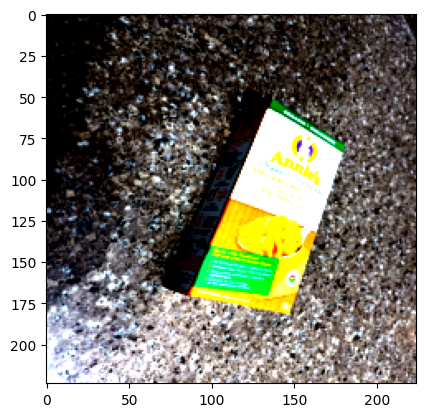

In [63]:
# Show an image from the batch.
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [64]:
class ResNet18(nn.Module):
    '''
    Pretrained CNN model to be used for image classification.
    '''
    def __init__(self, num_classes):
        # Initialize ResNet18 architecture.
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Modify the fully connected later to output num_classes.
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        # Forward pass through the model.
        return self.model(x)

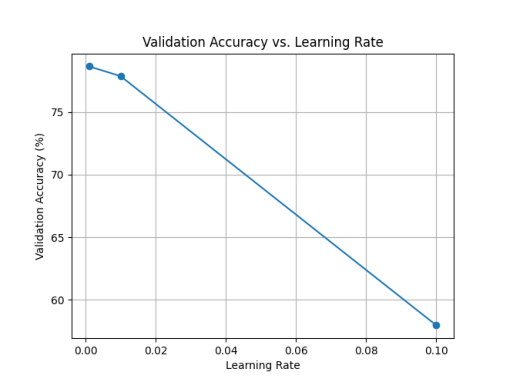

In [65]:
''' 
This is a grid-search  to determine the optimal hyper-parameters, however,
this was computationally expensive and took a long time to run.

Ideally, we would do this for all out hyperparameters, but this example only
covers the learning rate.

The code is commented out for simplicity.
The graph that was obtained earlier will be displayed below for reference. 
'''

# # Define the range of learning rates for grid search
# learning_rates = [0.001, 0.01, 0.1]
# validation_accuracies = []

# best_accuracy = 0
# best_learning_rate = 0
# nepochs = 20

# # Perform grid search over learning rates and store validation accuracies
# for lr in learning_rates:
#     print(f"Training with learning rate: {lr}")
    
#     # Define the model, criterion, optimizer, and scheduler with current learning rate
#     net = ResNet18(4)
#     net.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
#     scheduler = ExponentialLR(optimizer, gamma=0.9)
    
#     # Train the model
#     for epoch in range(nepochs):
#         train_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#         scheduler.step()
        
#     # Evaluate the model on the validation set
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in valloader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = net(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     accuracy = 100 * correct / total
#     validation_accuracies.append(accuracy)

# print("Grid search complete.")

# # Plot validation accuracy vs. learning rate
# plt.plot(learning_rates, validation_accuracies, marker='o')
# plt.xlabel('Learning Rate')
# plt.ylabel('Validation Accuracy (%)')
# plt.title('Validation Accuracy vs. Learning Rate')
# plt.grid(True)
# plt.savefig('validation_accuracy_vs_learning_rate.png')
# plt.close()

import matplotlib.image as mpimg
img = mpimg.imread('validation_accuracy_vs_learning_rate.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [66]:
# Initialize the model.
net = ResNet18(4)
net.to(device)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [67]:
# Define the loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [68]:
# Define the number of epochs.
nepochs = 20

# Define the path to save the best model.
PATH = './resnet18.pth'

# Initialize the best loss value.
best_loss = 1e+20

# Number of epochs to wait before early stopping.
patience = 5  
count = 0

# Create two lists to store training and validation loss values for each epoch.
train_loss_list = []
val_loss_list = []

# Training Loop.
for epoch in range(nepochs):
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Perform the forward pass.
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)

        # Perform the backward pass.
        loss.backward()

        # Perform optimization.
        optimizer.step()

        # Update the training loss.
        train_loss += loss.item()
    
    # Print the results to the display for the specific epoch.
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end=' ')
    train_loss_list.append(train_loss / (i + 1))
    scheduler.step()
    
    # Validation stage.
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(device), data[1].to(device) 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i + 1):.3f}')
        val_loss_list.append(val_loss / (i + 1))
        
        # Save the best model.
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
            count = 0  # Reset count if we found a better model
        else:
            count += 1
            # Early stopping.
            if count >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
print('Finished Training')


1,  train loss: 1.660, val loss: 1.145
Saving model
2,  train loss: 1.500, val loss: 1.159
3,  train loss: 1.221, val loss: 0.975
Saving model
4,  train loss: 0.971, val loss: 0.919
Saving model
5,  train loss: 1.002, val loss: 0.843
Saving model
Finished Training


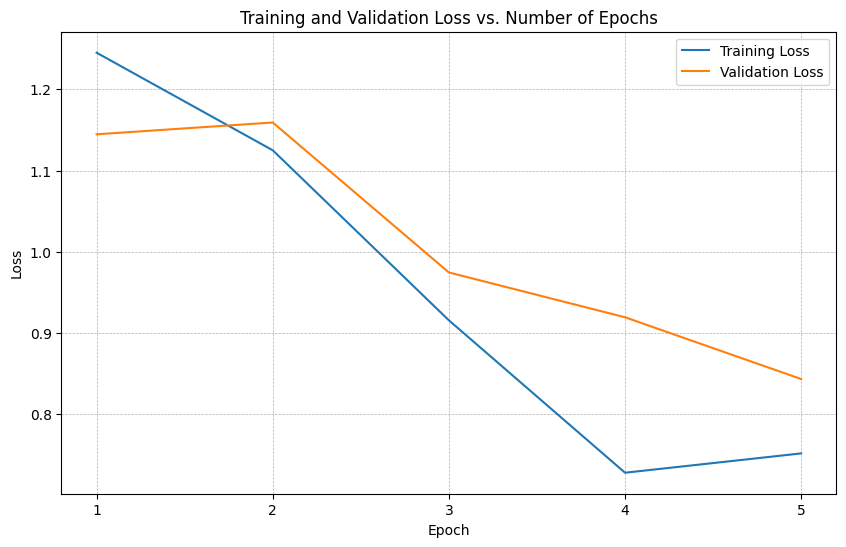

In [69]:
# Graph the train and val loss values over the number of epocse iterations. 
epochs = range(1, nepochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Number of Epochs')
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.xticks(epochs)
plt.show()

In [70]:
# Load the best model.
net = ResNet18(4)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [71]:
# Evaluate the model on the test set.
class_correct = [0 for _ in range(4)]
class_total = [0 for _ in range(4)]
overall_correct = 0
overall_total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network.
        outputs = net(images)

        # The class with the highest energy is what we choose as prediction.
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            overall_correct += (predicted[i] == label).item()
            overall_total += 1

# Print the accuracy of the network on the test images.
for i in range(4):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of class {i}: {accuracy:.2f} %')

overall_accuracy = 100 * overall_correct / overall_total if overall_total > 0 else 0
print(f'Overall accuracy: {overall_accuracy:.2f} %')


Accuracy of class 0: 40.00 %
Accuracy of class 1: 90.91 %
Accuracy of class 2: 71.43 %
Accuracy of class 3: 0.00 %
Overall accuracy: 57.58 %


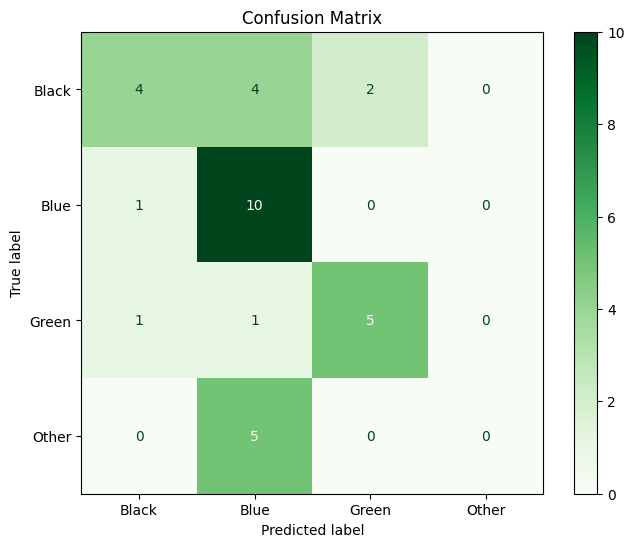

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize variables to store true labels and predicted labels.
true_labels = []
predicted_labels = []

# Since we're not training, we don't need to calculate the gradients for our outputs.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network.
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction.
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

classes = ['Black', 'Blue', 'Green', 'Other']

# Calculate the confusion matrix.
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display.
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Plot the confusion matrix.
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()
